# Assignment 3  - Amit Pawar

In this assignment, I have used Logistic Regression in its purest form first. To further enhance it, I have incorporated the same with PIPELINE API, with logistic regression, trainvalidationSplit and BinaryClassificationEvaluator for evaluating the model. I have used following HyperParameters - elasticNetParam, maxIter and regParam.

As further enhancement, I have demonstrated how RandomForestClassifier can further improve AUC.

## Customer Churn

Also known as customer attrition, or customer turnover is the loss of clients or customers. Customer churn is a critical metric because it is much less expensive to retain existing customers than it is to acquire new ones. 

Companies usually make a distinction between voluntary churn and involuntary churn. In most analyses involuntary churn is excluded. 

Predictive analytics uses machine learning to predict the likelihood of a customer churning. These models will identify a small subgroup of potential customers that are at a higher risk of abandoning the company. This empowers the company to focus on the subset of the customers who are most likely to churn and through customer retention marketing programs stop some of that to happen.


## Data

**Telco Customer Churn**

The data was downloaded from IBM Sample Data Sets: https://www.ibm.com/communities/analytics/watson-analytics-blog/guide-to-sample-datasets/

Each row represents a customer, each column contains customer's attributes described as below:

* **customerID**: Customer ID
* **gender**: Customer gender (female, male)
* **SeniorCitizen**: Whether the customer is a senior citizen or not (1, 0)
* **Partner**: Whether the customer has a partner or not (Yes, No)
* **Dependents**: Whether the customer has dependents or not (Yes, No)
* **tenure**: Number of months the customer has stayed with the company
* **PhoneService**: Whether the customer has a phone service or not (Yes, No)
* **MultipleLines**: Whether the customer has multiple lines or not (Yes, No, No phone service)
* **InternetService**: Customer's internet service provider (DSL, Fiber optic, No)
* **OnlineSecurity**: Whether the customer has online security or not (Yes, No, No internet service)
* **OnlineBackup**: Whether the customer has online backup or not (Yes, No, No internet service)
* **DeviceProtection**: Whether the customer has device protection or not (Yes, No, No internet service)
* **TechSupport**: Whether the customer has tech support or not (Yes, No, No internet service)
* **StreamingTV**: Whether the customer has streaming TV or not (Yes, No, No internet service)
* **StreamingMovies**: Whether the customer has streaming movies or not (Yes, No, No internet service)
* **Contract**: The contract term of the customer (Month-to-month, One year, Two year)
* **PaperlessBilling**: Whether the customer has paperless billing or not (Yes, No)
* **PaymentMethod**: The customer's payment method (Electronic check, Mailed check, Bank transfer (automatic), Credit card (automatic))
* **MonthlyCharges**: The amount charged to the customer monthly
* **TotalCharges**: The total amount charged to the customer
* **Churn**: Whether the customer churned or not (Yes or No)

The data set includes information about:

* Customers who left - the column is called `Churn`
* Services that each customer has signed up for - phone, multiple lines, internet, online security, online backup, device protection, tech support, and streaming TV and movies
* Customer account information - how long they've been a customer, contract, payment method, paperless billing, monthly charges, and total charges
* Demographic info about customers - gender, age range, and if they have partners and dependents

#### Importing libraries:

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from pyspark.sql.functions import *

# the following line gets the bucket name attached to our cluster
bucket = spark._jsc.hadoopConfiguration().get("fs.gs.system.bucket")

# specifying the path to our bucket where the data is located (no need to edit this path anymore)
data = "gs://" + bucket + "/notebooks/jupyter/data/"
print(data)

gs://is-843-avp-01/notebooks/jupyter/data/


#### Importing data:

In [2]:
df = spark.read.format("csv")\
  .option("header", "true")\
  .option("inferschema", True)\
  .load(data + "Telco-Customer-Churn.csv2")\
  .coalesce(5)

df = df.drop('customerID')  # Dropping customerID
df.cache()
df.show(5)
df.printSchema()
print("This datasets consists of {} rows.".format(df.count()))

+------+-------------+-------+----------+------+------------+--------------+---------------+--------------+------------+----------------+-----------+-----------+---------------+--------------+----------------+--------------------+--------------+------------+-----+
|gender|SeniorCitizen|Partner|Dependents|tenure|PhoneService| MultipleLines|InternetService|OnlineSecurity|OnlineBackup|DeviceProtection|TechSupport|StreamingTV|StreamingMovies|      Contract|PaperlessBilling|       PaymentMethod|MonthlyCharges|TotalCharges|Churn|
+------+-------------+-------+----------+------+------------+--------------+---------------+--------------+------------+----------------+-----------+-----------+---------------+--------------+----------------+--------------------+--------------+------------+-----+
|Female|            0|    Yes|        No|     1|          No|NoPhoneService|            DSL|            No|         Yes|              No|         No|         No|             No|Month_to_month|             

#### Checking for missing values:

In [3]:
[(c, df.where(col(c).isNull()).count()) for c in df.columns]

[('gender', 0),
 ('SeniorCitizen', 0),
 ('Partner', 0),
 ('Dependents', 0),
 ('tenure', 0),
 ('PhoneService', 0),
 ('MultipleLines', 0),
 ('InternetService', 0),
 ('OnlineSecurity', 0),
 ('OnlineBackup', 0),
 ('DeviceProtection', 0),
 ('TechSupport', 0),
 ('StreamingTV', 0),
 ('StreamingMovies', 0),
 ('Contract', 0),
 ('PaperlessBilling', 0),
 ('PaymentMethod', 0),
 ('MonthlyCharges', 0),
 ('TotalCharges', 11),
 ('Churn', 0)]

There are 11 missing values in `TotalCharges`. Let's fill them with 0 since they seem to be new customers:

In [4]:
df = df.fillna(0)

#### Define an RFormula that uses all of the columns as features and call it `supervised`:

In [5]:
# Your answer goes here
from pyspark.ml.feature import RFormula

supervised = RFormula(formula="Churn ~ . ")

#### Fit the RFormula transformer and call it `fittedRF`:

In [6]:
# Your answer goes here
fittedRF = supervised.fit(df)  # fit the transformer

#### Using `fittedRF` transform our `df` DataFrame. Call this `preparedDF`:

In [7]:
preparedDF = fittedRF.transform(df)

Print the first couple of rows of 'preparedDF' with the truncate option as 'off':

In [8]:
preparedDF.show(5, truncate=False)

23/04/24 11:34:07 WARN package: Truncated the string representation of a plan since it was too large. This behavior can be adjusted by setting 'spark.sql.debug.maxToStringFields'.


+------+-------------+-------+----------+------+------------+--------------+---------------+--------------+------------+----------------+-----------+-----------+---------------+--------------+----------------+---------------------+--------------+------------+-----+------------------------------------------------------------------------------------------------------------------------------------+-----+
|gender|SeniorCitizen|Partner|Dependents|tenure|PhoneService|MultipleLines |InternetService|OnlineSecurity|OnlineBackup|DeviceProtection|TechSupport|StreamingTV|StreamingMovies|Contract      |PaperlessBilling|PaymentMethod        |MonthlyCharges|TotalCharges|Churn|features                                                                                                                            |label|
+------+-------------+-------+----------+------+------------+--------------+---------------+--------------+------------+----------------+-----------+-----------+---------------+-------------

In [9]:
preparedDF.select('features', 'label').show(2, False)

+-----------------------------------------------------------------------------------------------------------------------+-----+
|features                                                                                                               |label|
+-----------------------------------------------------------------------------------------------------------------------+-----+
|(30,[3,4,9,10,13,14,16,18,20,22,24,25,28,29],[1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,29.85,29.85])            |0.0  |
|(30,[0,2,3,4,5,6,9,11,12,15,16,18,20,26,28,29],[1.0,1.0,1.0,34.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,56.95,1889.5])|0.0  |
+-----------------------------------------------------------------------------------------------------------------------+-----+
only showing top 2 rows



#### Below we will retrieve the name of the columns used to make our feature vector and store them in a pandas DataFrame:

In [38]:
# Your answer goes here
featureCols = pd.DataFrame(preparedDF.schema["features"].metadata["ml_attr"]["attrs"]["binary"]+
  preparedDF.schema["features"].metadata["ml_attr"]["attrs"]["numeric"]).sort_values("idx")

featureCols = featureCols.set_index('idx')
featureCols.head()

,name
idx,
0,gender_Male
1,SeniorCitizen
2,Partner_No
3,Dependents_No
4,tenure


#### Split the transformed data into `train` and `test`. Use a 30% split and a `seed`.

In [10]:
# Your answer goes here
train, test = preparedDF.randomSplit([0.7, 0.3], seed = 843)
test.show(1)

+------+-------------+-------+----------+------+------------+--------------+---------------+--------------+------------+----------------+-----------+-----------+---------------+--------------+----------------+---------------+--------------+------------+-----+--------------------+-----+
|gender|SeniorCitizen|Partner|Dependents|tenure|PhoneService| MultipleLines|InternetService|OnlineSecurity|OnlineBackup|DeviceProtection|TechSupport|StreamingTV|StreamingMovies|      Contract|PaperlessBilling|  PaymentMethod|MonthlyCharges|TotalCharges|Churn|            features|label|
+------+-------------+-------+----------+------+------------+--------------+---------------+--------------+------------+----------------+-----------+-----------+---------------+--------------+----------------+---------------+--------------+------------+-----+--------------------+-----+
|Female|            0|     No|        No|     1|          No|NoPhoneService|            DSL|            No|          No|              No|  

#### Instantiate an instance of `LogisticRegression`. Call it `lr`:

In [19]:
# Your answer goes here
from pyspark.ml.classification import LogisticRegression

lr = LogisticRegression()

#### Print the parameters of `lr` to check the default values used. You can always come back to the cell above and change the default values:

In [20]:
# Your answer goes here
print(lr.explainParams())

aggregationDepth: suggested depth for treeAggregate (>= 2). (default: 2)
elasticNetParam: the ElasticNet mixing parameter, in range [0, 1]. For alpha = 0, the penalty is an L2 penalty. For alpha = 1, it is an L1 penalty. (default: 0.0)
family: The name of family which is a description of the label distribution to be used in the model. Supported options: auto, binomial, multinomial (default: auto)
featuresCol: features column name. (default: features)
fitIntercept: whether to fit an intercept term. (default: True)
labelCol: label column name. (default: label)
lowerBoundsOnCoefficients: The lower bounds on coefficients if fitting under bound constrained optimization. The bound matrix must be compatible with the shape (1, number of features) for binomial regression, or (number of classes, number of features) for multinomial regression. (undefined)
lowerBoundsOnIntercepts: The lower bounds on intercepts if fitting under bound constrained optimization. The bounds vector size must beequal wi

#### Fit the model on `train` and call it `lrModel`:

In [21]:
# Your answer goes here
lrModel = lr.fit(train)

#### Below we plot the coefficients of our model in a sorted fashion:

In [22]:
# Your answer goes here
plt.rcParams["figure.figsize"] = (8,6)

Text(0, 0.5, 'Beta Coefficients')

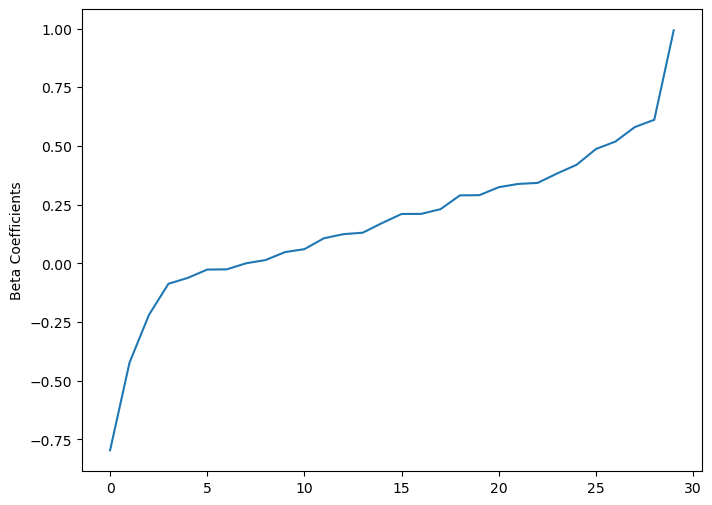

In [23]:
# Your answer goes here
beta = np.sort(lrModel.coefficients)
plt.plot(beta)
plt.ylabel('Beta Coefficients')

#### Feature importance

We already retrieved the name of the features. Let's join it with the coefficients to identify the ones with bigger absolute value:

In [24]:
# Your answer goes here
coefsArray = np.array(lrModel.coefficients)  # convert to np.array
coefsDF = pd.DataFrame(coefsArray, columns=['coefs'])  # to pandas

coefsDF = coefsDF.merge(featureCols, left_index=True, right_index=True)  # join it with featureCols we created above
coefsDF.sort_values('coefs', inplace=True)  # Sort them
coefsDF.head()

,coefs,name
23,-0.796201,Contract_TwoYear
9,-0.422971,InternetService_DSL
6,-0.219693,MultipleLines_No
0,-0.087097,gender_Male
4,-0.061813,tenure


#### Plot a bar chart:

In [25]:
# Your answer goes here
plt.rcParams["figure.figsize"] = (20,3)

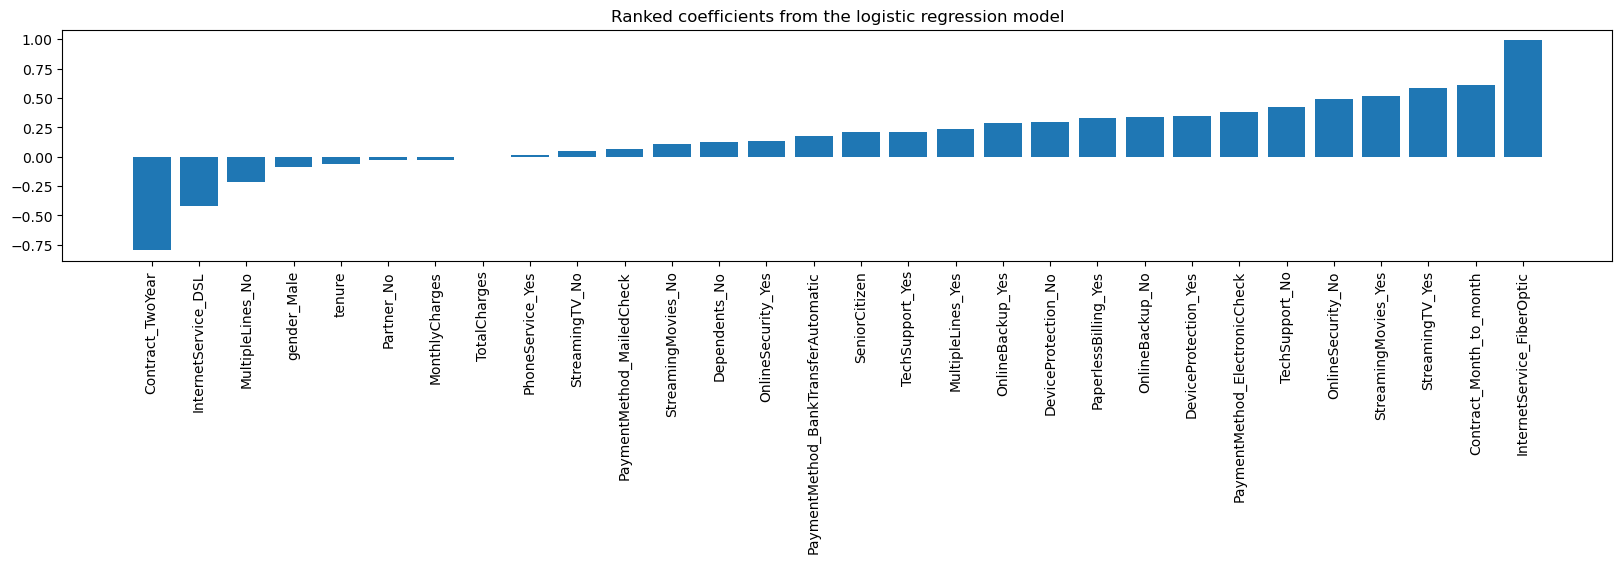

In [26]:
# Your answer goes here
plt.xticks(rotation=90)
plt.bar(coefsDF.name, coefsDF.coefs)
plt.title('Ranked coefficients from the logistic regression model')
plt.show()

From our fitted model, `lrModel`, extract the summary and call it `summary`:

In [27]:
# Your answer goes here
summary = lrModel.summary

From `summary` extract `areaUnderROC`. Note that this AUC is from the `train` dataset and we should pay more attention to the AUC coming from the `test` set:

In [28]:
# Your answer goes here
# Your answer goes here
print("Train AUC:", summary.areaUnderROC)

Train AUC: 0.8476784520669891


#### From `summary` extract `roc` and convert it to a pandas DataFrame. Call it `roc`:

In [29]:
# Your answer goes here
roc = summary.roc.toPandas()
roc.head()

,FPR,TPR
0,0.000000,0.000000
1,0.000000,0.003046
2,0.000000,0.006093
3,0.000556,0.007616
4,0.000556,0.010663


#### Visualize the `roc` DataFrame:

In [30]:
# Your answer goes here
plt.rcParams["figure.figsize"] = (8,6)

Train AUC: 0.8476784520669891


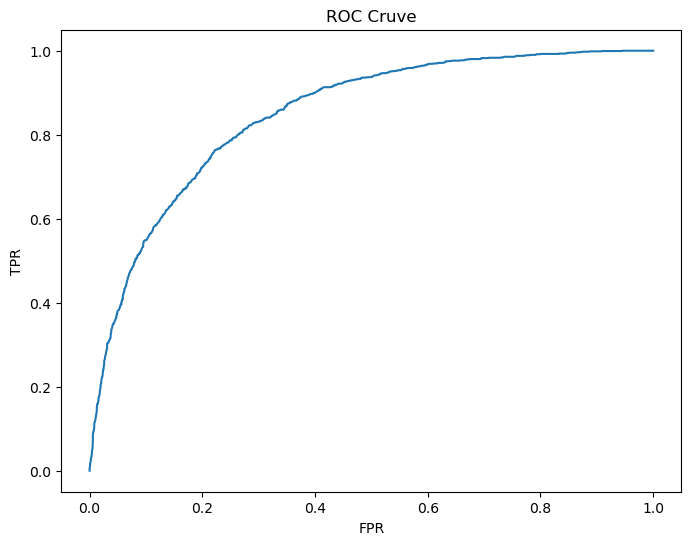

In [31]:
# Your answer goes here
roc.plot(x='FPR', y='TPR', style='-', legend=False)
plt.title('ROC Cruve')
plt.ylabel('TPR')

print('Train AUC:', summary.areaUnderROC)

Do the same with `pr` from `summary`:

Text(0, 0.5, 'precision')

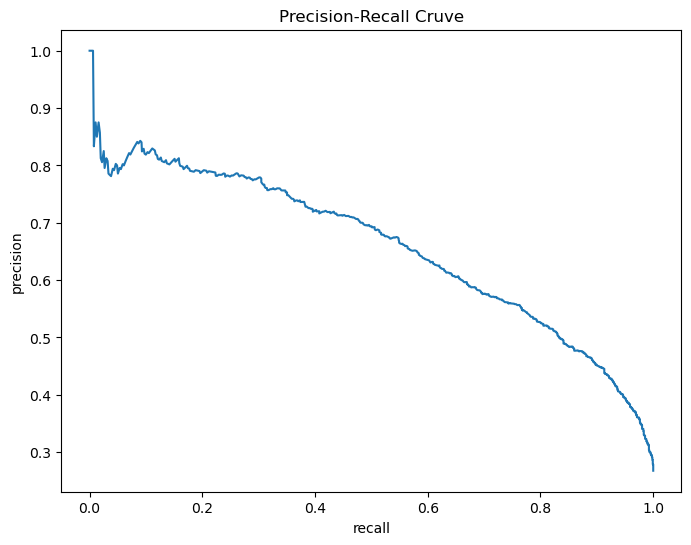

In [32]:
# Your answer goes here
pr = summary.pr.toPandas()
pr.plot(x='recall', y='precision', style='-', legend=False)
plt.title('Precision-Recall Cruve')
plt.ylabel('precision')

Our baseline model looks promising. Let's do some predictions on the `test` set.

Pass the `test` set through our trained model. Called the resulting DataFrame `fittedTest`:

In [33]:
# Your answer goes here
fittedTest = lrModel.transform(test)

#### Print the first few rows of this DataFrame. Only show the following columns: "label", "prediction", "rawPrediction"

In [34]:
# Your answer goes here
fittedTest.select("label", "prediction", "rawPrediction").show(5, False)

+-----+----------+------------------------------------------+
|label|prediction|rawPrediction                             |
+-----+----------+------------------------------------------+
|1.0  |1.0       |[-0.44107484269531416,0.44107484269531416]|
|0.0  |1.0       |[-0.4246668575808312,0.4246668575808312]  |
|1.0  |1.0       |[-0.26692243640267055,0.26692243640267055]|
|0.0  |0.0       |[0.2404528963121727,-0.2404528963121727]  |
|0.0  |0.0       |[0.46900054822864723,-0.46900054822864723]|
+-----+----------+------------------------------------------+
only showing top 5 rows



Make an evaluator from `BinaryClassificationEvaluator` function that calculates AUC. We will use this function to measure our model's performance on the `test` set. Call this evaluator `aucEvaluator`. 

Note that this function can be found under the `pyspark.ml.evaluation` module.

In [35]:
# Your answer goes here
from pyspark.ml.evaluation import BinaryClassificationEvaluator

aucEvaluator = BinaryClassificationEvaluator(metricName='areaUnderROC')

Using our `aucEvaluator` find out the AUC on the `test` set:

In [36]:
# Your answer goes here
print('Test AUC:', aucEvaluator.evaluate(lrModel.transform(test)))
print('Train AUC:', summary.areaUnderROC)

Test AUC: 0.8488678638837974
Train AUC: 0.8476784520669891



# Next Steps - MODEL ENHANCEMENT - PIPELINE

* Use of pipeline API and create a grid search to tune the hyperparameters.
* Logistics regression as regression model.
* Use of trainvalidationSplit.
* BinaryClassificationEvaluator for evaluating the model.
* Hyperparameters - elasticNetParam, maxIter and regParam.

In [14]:
from pyspark.ml import Pipeline
from pyspark.ml.tuning import ParamGridBuilder, TrainValidationSplit
from pyspark.ml.evaluation import BinaryClassificationEvaluator
from pyspark.ml.feature import RFormula
from pyspark.ml.classification import LogisticRegression

In [32]:
train, test = df.randomSplit([0.7, 0.3], seed = 843)  # create a holdout set before transformation
rForm = RFormula()  # defining stage 1 by creating an empty R formula
lr = LogisticRegression().setLabelCol("label").setFeaturesCol("features")  # defining stage 2 by instantiating an instance of LogisticRegression


In [33]:
stages = [rForm, lr]  # setting the stages
pipeline = Pipeline().setStages(stages)  # adding the stages to the pipeline

In [34]:
# building the hyperparameter grid

params = ParamGridBuilder()\
  .addGrid(rForm.formula, ["Churn ~ . "])\
  .addGrid(lr.elasticNetParam, [0.0, 0.5, 1.0])\
  .addGrid(lr.maxIter, [10, 50, 100])\
  .addGrid(lr.regParam, [0.1,1.0, 2.0])\
  .build()

In [35]:
#How many models now?
print ('Number of models to be tested: ', len(params))

Number of models to be tested:  27


In [37]:
# setting the evaluator as AUC
evaluator = BinaryClassificationEvaluator(metricName='areaUnderROC')
#evaluator = BinaryClassificationEvaluator()

In [45]:
# defining Train Validation Split to be used for hypyerparameter tuning
tvs = TrainValidationSplit()\
  .setTrainRatio(0.75)\
  .setEstimatorParamMaps(params)\
  .setEstimator(pipeline)\
  .setEvaluator(evaluator)

In [ ]:
tvsFitted = tvs.fit(train)  # fit the estimator

#### Area Under Curve and Best model.

In [40]:
evaluator.evaluate(tvsFitted.transform(test))  # evaluate the test set (AUC)

0.846645877214579

In [41]:
# Used code from Sindhura Uppalapati
bestParams = tvsFitted.bestModel.stages[-1].extractParamMap()
for param in bestParams:
    print(param.name, bestParams[param])

aggregationDepth 2
elasticNetParam 0.0
family auto
featuresCol features
fitIntercept True
labelCol label
maxBlockSizeInMB 0.0
maxIter 50
predictionCol prediction
probabilityCol probability
rawPredictionCol rawPrediction
regParam 0.1
standardization True
threshold 0.5
tol 1e-06


In [42]:
# Finding predictions using test data
predictions = tvsFitted.transform(test)

In [43]:
# Printing labels and predictions

predictions.select("probability", "prediction", "label").show(10, False)

+----------------------------------------+----------+-----+
|probability                             |prediction|label|
+----------------------------------------+----------+-----+
|[0.5353697669993327,0.4646302330006673] |0.0       |1.0  |
|[0.5347407090251565,0.46525929097484353]|0.0       |0.0  |
|[0.578298229311523,0.42170177068847703] |0.0       |1.0  |
|[0.6897423675840849,0.3102576324159151] |0.0       |0.0  |
|[0.6616899053854153,0.3383100946145847] |0.0       |0.0  |
|[0.6568699686345119,0.34313003136548814]|0.0       |0.0  |
|[0.5257129785651296,0.47428702143487045]|0.0       |1.0  |
|[0.6047038629944821,0.3952961370055179] |0.0       |1.0  |
|[0.603913163196855,0.39608683680314505] |0.0       |1.0  |
|[0.48905648714238237,0.5109435128576176]|1.0       |1.0  |
+----------------------------------------+----------+-----+
only showing top 10 rows



# Other ideas to improve - Random Forest Classifier + Cross Validator

(1)
Random Forest is an ensemble of Decision trees. 

It is powerful because each of the trees works on different subset of data and furthermore, random subset of features are used for splitting at each decision node.

We can increase the number of trees by defining - forest = RandomForestClassifier(numTrees = 100)

Additionally, we can increase the number of folds in cross validator to more significant values like 10 or more.

Since DataProc cluster is not big enough, I kept the value to 2 so that fitting will finish.

(2) Additionally, we can also clean up the data a bit more. Instead of using df = df.fillna(0), we could use average to fill up the NULL values.

In [12]:
# Create a random forest classifier
from pyspark.ml.classification import RandomForestClassifier
forest = RandomForestClassifier()

In [15]:
# Create a parameter grid
params = ParamGridBuilder() \
            .addGrid(forest.featureSubsetStrategy, ['all', 'onethird', 'sqrt', 'log2']) \
            .addGrid(forest.maxDepth, [2, 5, 10]) \
            .build()

In [16]:
# Create a binary classification evaluator
evaluator = BinaryClassificationEvaluator()

In [21]:
# Create a cross-validator
from pyspark.ml.tuning import CrossValidator
cv = CrossValidator(estimator=forest, estimatorParamMaps=params, evaluator=evaluator, numFolds=2)

In [22]:
# Fitting the training data
cv = cv.fit(train)

23/04/24 11:39:18 WARN DAGScheduler: Broadcasting large task binary with size 1214.3 KiB
23/04/24 11:39:24 WARN DAGScheduler: Broadcasting large task binary with size 1081.6 KiB
23/04/24 11:39:24 WARN DAGScheduler: Broadcasting large task binary with size 1385.6 KiB
23/04/24 11:39:25 WARN DAGScheduler: Broadcasting large task binary with size 1023.7 KiB
23/04/24 11:39:29 WARN DAGScheduler: Broadcasting large task binary with size 1062.6 KiB
23/04/24 11:39:30 WARN DAGScheduler: Broadcasting large task binary with size 1381.2 KiB
23/04/24 11:39:34 WARN DAGScheduler: Broadcasting large task binary with size 1051.1 KiB
23/04/24 11:39:35 WARN DAGScheduler: Broadcasting large task binary with size 1356.7 KiB
23/04/24 11:39:42 WARN DAGScheduler: Broadcasting large task binary with size 1194.1 KiB
23/04/24 11:39:47 WARN DAGScheduler: Broadcasting large task binary with size 1038.1 KiB
23/04/24 11:39:47 WARN DAGScheduler: Broadcasting large task binary with size 1325.6 KiB
23/04/24 11:39:52 WAR

In [23]:
# Average AUC for each parameter combination in grid
print(cv.avgMetrics)

[0.7903966667942398, 0.8377128793700483, 0.8124278610091478, 0.8211577540485218, 0.8371427280483092, 0.8199488344849769, 0.815034643129674, 0.833694489133825, 0.8250913863643845, 0.8180109309847363, 0.8328327480608985, 0.8189841423054736]


In [27]:
# What's the optimal parameter value for maxDepth?
print(cv.bestModel.explainParam('maxDepth'))


maxDepth: Maximum depth of the tree. (>= 0) E.g., depth 0 means 1 leaf node; depth 1 means 1 internal node + 2 leaf nodes. Must be in range [0, 30]. (default: 5, current: 5)


In [28]:
# What's the optimal parameter value for featureSubsetStrategy?
print(cv.bestModel.explainParam('featureSubsetStrategy'))

featureSubsetStrategy: The number of features to consider for splits at each tree node. Supported options: 'auto' (choose automatically for task: If numTrees == 1, set to 'all'. If numTrees > 1 (forest), set to 'sqrt' for classification and to 'onethird' for regression), 'all' (use all features), 'onethird' (use 1/3 of the features), 'sqrt' (use sqrt(number of features)), 'log2' (use log2(number of features)), 'n' (when n is in the range (0, 1.0], use n * number of features. When n is in the range (1, number of features), use n features). default = 'auto' (default: auto, current: all)


In [29]:
# AUC for best model on testing data
print(evaluator.evaluate(cv.transform(test)))

0.8514226641500484


In [36]:
#Best Model
cv.bestModel

RandomForestClassificationModel: uid=RandomForestClassifier_77c664a49a8a, numTrees=20, numClasses=2, numFeatures=30

In [41]:
# Finding the feature importance
features_impt = cv.bestModel.featureImportances

In [66]:
# Converting sparse vector to Dataframe
from  pyspark.mllib.linalg import SparseVector
pd_impt = pd.DataFrame(features_impt.toArray())

In [67]:
# Renaming the column of dataframe
pd_impt = pd_impt.rename(columns={0: "feature"})

In [68]:
pd_impt.head(4)

,feature
0,0.002581
1,0.003514
2,0.000458
3,0.000336


In [69]:
# Merging the same to featureCols
pd_impt = pd_impt.merge(featureCols, left_index=True, right_index=True)  # join it with featureCols we created above

In [73]:
# Sorting and printing the feature importance
pd_impt.sort_values('feature', inplace=True)  # Sort them


In [74]:
pd_impt

,feature,name
19,0.000000,StreamingTV_Yes
9,0.000000,InternetService_DSL
11,0.000000,OnlineSecurity_Yes
15,0.000000,DeviceProtection_Yes
13,0.000000,OnlineBackup_Yes
17,0.000091,TechSupport_Yes
14,0.000259,DeviceProtection_No
26,0.000281,PaymentMethod_MailedCheck
3,0.000336,Dependents_No
7,0.000341,MultipleLines_Yes


# Final Summary:

AUC with Logistic Regression    :  0.8476784520669891

AUC with Pipelines              :  0.846645877214579

AUC with RandomForest           :  0.8514226641500484